# TODO:

- store output of state vars in xarray-simlab data structure
    1. for gekko solver
    2. for odeint solver
    3. for step-wise solver
    
this needs to be completely wrapped in the backend..
i need to somehow combine the "core.parts" so that they are automatically initialized with the xs.Model

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import xsimlab as xs

# to measure process time
import time as tm

In [2]:
from xsimlab.monitoring import ProgressBar

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [4]:
from phydra.processes.statevars import SV, Time

from phydra.processes.forcings import ConstantForcing

from phydra.processes.fluxes import LinearOutputFlux, ForcingLinearInputFlux

In [5]:
Model = phydra.create({
    # SV
    'y':SV,
    'x':SV,
    
    # Fluxes
    'y_loss':LinearOutputFlux,
    'x_loss':LinearOutputFlux,
    
    # Forcing
    'y_input':ForcingLinearInputFlux,
    'N0':ConstantForcing
})

In [6]:
Model

<xsimlab.Model (9 processes, 12 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
y
    init            [in]
x
    init            [in]
N0
    value           [in]
y_loss
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
x_loss
    rate            [in] flowing rate
    sv              [in] state variable affected by flux
y_input
    sv              [in] state variable affected by forcing flux
    fx              [in] forcing linearly affecting rate
    rate            [in] flowing rate
Solver

In [7]:
#Model.visualize(show_inputs=True)

In [8]:
odeint_setup = phydra.setup('odeint', Model,
            time=np.arange(0,20,0.1),
            input_vars={
                'y__init':0.5,
                'x__init':0.5,
                
                'y_loss':{'sv':'y',
                          'rate':.01},
                
                'x_loss':{'sv':'x',
                          'rate':.5},
                
                'y_input':{'sv':'y',
                          'fx':'N0',
                          'rate':.5},
                'N0__value':2.
            },
            output_vars={
                'y__value':None,
                'x__value':None,
            })

In [9]:
gekko_setup = phydra.update_setup(model=Model, old_setup=odeint_setup, new_solver="gekko")

In [10]:
stepwise_setup = phydra.update_setup(model=Model, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [11]:
stepwise_setup

<xarray.Dataset>
Dimensions:            (clock: 200, input_time: 200)
Coordinates:
  * clock              (clock) float64 0.0 0.1 0.2 0.3 ... 19.6 19.7 19.8 19.9
Dimensions without coordinates: input_time
Data variables:
    y__init            float64 0.5
    x__init            float64 0.5
    y_loss__sv         <U1 'y'
    y_loss__rate       float64 0.01
    x_loss__sv         <U1 'x'
    x_loss__rate       float64 0.5
    y_input__sv        <U1 'y'
    y_input__fx        <U2 'N0'
    y_input__rate      float64 0.5
    N0__value          float64 2.0
    Time__time         (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    Core__solver_type  <U8 'stepwise'
Attributes:
    __xsimlab_output_vars__:  y__value,x__value

and solve the model like this:

In [12]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=Model)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing forcing N0
initializing flux y_loss
initializing flux x_loss
initializing flux y_input
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.00195 seconds
here unpacking values time
here unpacking values y
here unpacking values x
finalizing: cleanup


In [13]:
out_ds

<xarray.Dataset>
Dimensions:            (clock: 2, input_time: 200, time: 200)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type  <U6 'odeint'
    N0__value          float64 2.0
    Time__time         (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    x__init            float64 0.5
    x__value           (time) float64 0.5 0.4756 0.4524 ... 2.509e-05 2.386e-05
    x_loss__rate       float64 0.5
    x_loss__sv         <U1 'x'
    y__init            float64 0.5
    y__value           (time) float64 0.5 0.5995 0.6988 ... 18.29 18.37 18.45
    y_input__fx        <U2 'N0'
    y_input__rate      float64 0.5
    y_input__sv        <U1 'y'
    y_loss__rate       float64 0.01
    y_loss__sv         <U1 'y'

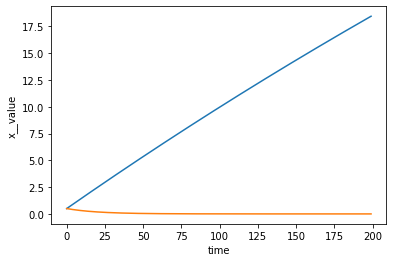

In [14]:
out_ds.y__value.plot()
out_ds.x__value.plot()

In [15]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=Model)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing forcing N0
initializing flux y_loss
initializing flux x_loss
initializing flux y_input
assembling model
SOLVER : gekko
Model was solved in 0.13 seconds
finalizing: cleanup


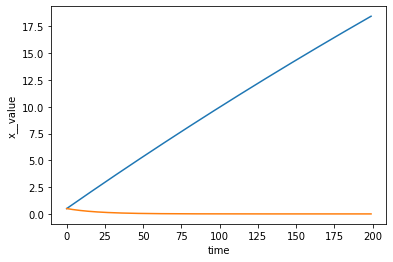

In [16]:
out_ds1.y__value.plot()
out_ds1.x__value.plot()

In [17]:
with ProgressBar(frontend="console"):
        out_ds2 = stepwise_setup.xsimlab.run(model=Model)

███████     71% | run step 141/199 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing forcing N0
initializing flux y_loss
initializing flux x_loss
initializing flux y_input
assembling model
SOLVER : stepwise


██████████ 100% | Simulation finished in 00:00 

finalizing: cleanup


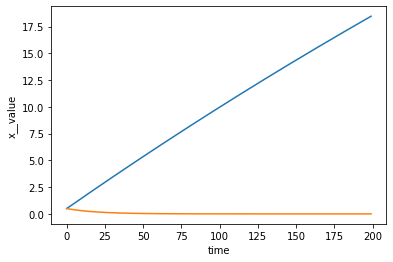

In [18]:
out_ds2.y__value.plot()
out_ds2.x__value.plot()